# word2vec

本章使用基于推理的方法构建一个简单的word2vec，注重于易理解性，从而牺牲一定的处理效率，因此，更适合处理小规模数据集。

## 3.1基于推理的方法和神经网络

### 3.1.1基于计数的方法的问题

基于计数的方法根据一个单词周围的单词的出现频数来表示该单词。

具体来说，现生成所有单词的共现矩阵，再对这个矩阵进行SVD，以获得密集向量即单词的分布式表示。

但是当词汇量较大时，使用计数的方法就不现实了，而且是一次性处理全部数据。

基于推理的方法使用部分数据逐步学习。

### 3.1.2基于推理的方法

**推理**：当给出周围的单词即上下文时，预测？处会出现什么单词。
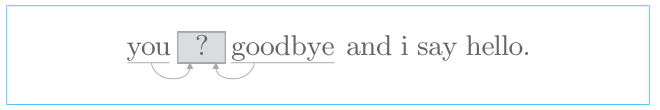

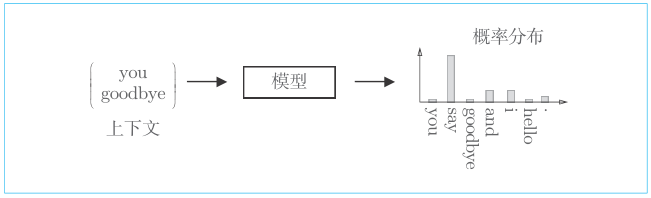

基于推理的方法引入了某种模型。这个模型接收上下文信息作为输入，并输出可能出现的各个单词的出现概率。

基于推理的方法和基于计数的方法一样，也是基于“分布式假设”。分布式假设指单词含义由其周围的单词构成。

### 3.1.3 神经网络中单词的处理方法

神经网络无法直接处理you或say这样的单词，要用神经网络处理单词，需要先将单词转换为固定长度的向量。

如one-hot向量

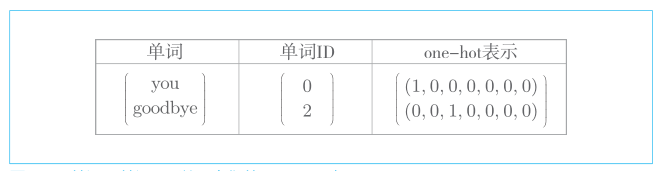

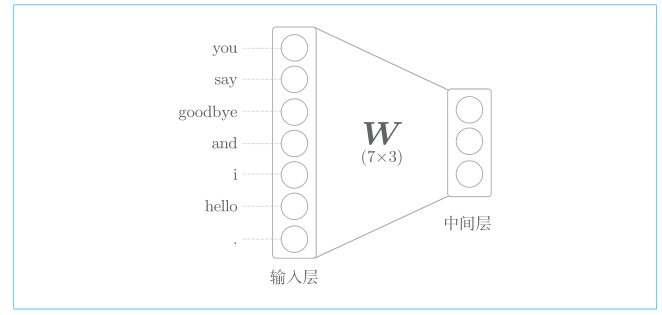

In [4]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(c, W)
print(h)

[[-0.37916953  0.61804867 -0.72771135]]


c和W的矩阵乘积相当于提取权重对应的行向量。

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

In [6]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 0.18447114 -1.74240074 -0.52101048]]


## 3.2 简单的word2vec

由原版word2vec提出的continuous bag-of-words(CBOW)的模型作为神经网络。

word2vec一词最初指程序或者工具，某些语境下，也指神经网络的模型。

CBOW模型和skip-gram模型是word2vec中使用的两个神经网络。

### 3.2.1 CBOW模型的推理

这里假设上下文仅考虑两个单词，所以输入层有两个。如果对上下文考虑N个单词，则输入层有N个。

中间层的神经元是各个输入层经全连接层变换后得到的值的平均。

对输出层的得分应用Softmax函数，就可以得到概率。

**中间层的神经元数量比输入层少这一点很重要。中间层需要将预测单词所需的信息压缩保存，从而产生密集的向量表示。这时，中间层被写入了我们人类无法解读的代码，这相当于“编码”工作。而从中间层的信息获得期望结果的过程则称为“解码”。这一过程将被编码的信息复原为我们可以理解的形式。**

层视角下的CBOW模型的网络结构

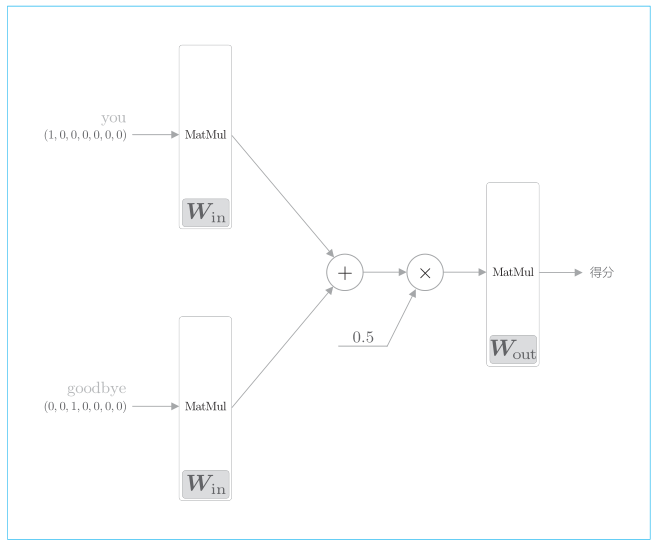

In [11]:
# 权重的上下文数据
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 权重的初始值
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 生成层
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 正向传播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)


[[ 0.22511462  0.19085659 -0.91241585 -0.32666005  1.46355798  2.43687385
  -0.38512022]]


### 3.2.2 CBOW模型的学习

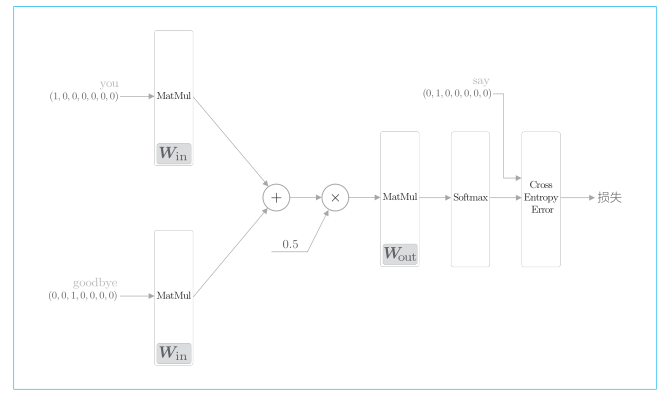

### 3.2.3 word2vec的权重和分布式表示

一般而言，输入侧的权重 Win 的每一行对应于各个单词的分布式表示。另外，输出侧的权重 Wout也同样保存了对单词含义进行了编码的向量。

输出侧的权重在列方向上保存了各个单词的分布式表示。

**就word2vec（特别是 skip-gram 模型）而言，最受欢迎的是方案 A。许多研究中也都仅使用输入侧的权重 Win作为最终的单词的分布式表示。遵循这一思路，我们也使用 Win作为单词的分布式表示**

## 3.3 学习数据的准备

### 3.3.1 上下文和目标词

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


从语料库生成上下文和目标词，**两端的单词除外**


In [13]:
def create_contexts_target(corpus, window_size=1):
    '''生成上下文和目标词

    :param corpus: 语料库（单词ID列表）
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return:
    '''
    target = corpus[window_size:-window_size] # 排除两端单词
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [14]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [15]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 转换成one-hot表示

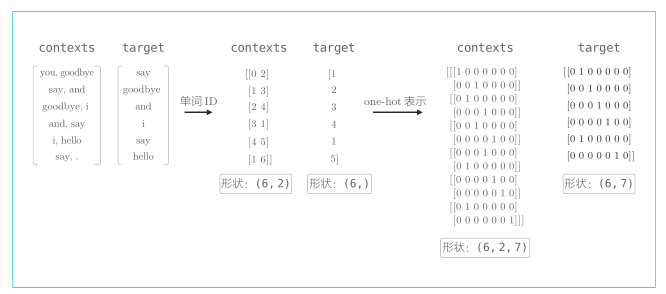

In [16]:
def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示

    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]
    
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

In [17]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [19]:
print(target)
print('####')
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
####
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW模型的实现

CBOW模型的搭建见simple_cbow

学习`的过程见train

## 3.5 word2vec的补充说明 

### 3.5.1 CBOW模型和概率（窗口为1）

给定上下文$w_{t-1}$和$w_{t+1}$时目标词为$w_t$的概率


一个样本数据的损失函数 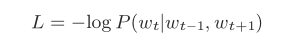

整个语料库的损失函数
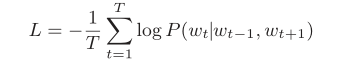

### 3.5.2 skip-gram模型

skip-gram模型是反转了CBOW 模型处理的上下文和目标词的模型。

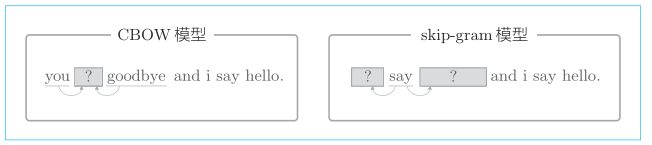

同理，用概率表示有：

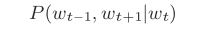

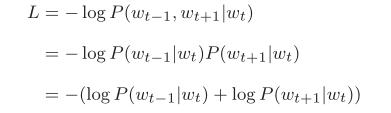

**那么，我们应该使用 CBOW 模型和 skip-gram 模型中的哪一个呢？答案应该是 skip-gram 模型。这是因为，从单词的分布式表示的准确度来看，在大多数情况下，skip-grm 模型的结果更好。特别是随着语料库规模的增大，在低频词和类推问题的性能方面，skip-gram 模型往往会有更好的表现。此外，就学习速度而言，CBOW模型比skip-gram模型更快。**
可以说 skip-gram 模型要解决的是更难的问题。经过这个更难的问题的锻炼，skip-gram 模型能提供更好的单词的分布式表示。

**模型的搭建见simple_skip_gram**

### 3.5.3 基于计数与基于推理 

考虑需要向词汇表添加新词并更新单词的分布式表示的场景。此时，基于计数的方法需要从头开始计算。基于推理的方法（word2vec）允许参数的增量学习。

就分布式表示的性质而言，基于计数的方法主要是编码单词的相似性，而 word2vec（特别是 skip-gram 模型）除了单词的相似性以外，还能理解更复杂的单词之间的模式。

一个常见的误解，那就是基于推理的方法在准确度方面优于基于计数的方法。实际上，有研究表明，就单词相似性的定量评价而言，基于推理的方法和基于计数的方法难分上下。

基于推理的方法和基于计数的方法存在关联性。

基于推理的方法和基于计数的方法存在关联性。